**Hello**. This Jupyter notebook details the statistical estimation of an asset valuation model that I am currently working on. The model constitutes the central part of my thesis project (Economics) at COLMEX. The datasets are publicly availlable online, and the sources are cited below. All the mathematical details and theoretical results are written down in the main body of the thesis document, which will available once it is (hopefully) approved.

# Data sources

* Historical asset returns for USA:

http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/histretSP.html

* Real per capita consumption for USA:

https://fred.stlouisfed.org/series/A794RX0Q048SBEA

* Consumer price index for USA:

https://fred.stlouisfed.org/series/CPIAUCSL

# Data preparation

In [262]:
# Import requiered libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kstest, anderson

# 'pub_quality' is a flag variable:
# - If true, automatically exports all plots to PDF at 200 dpi.
# - If false, all plots are displayed inline al 70 dpi.
pub_quality = False

if pub_quality:
    plt.rcParams['figure.dpi']= 200
else:
    plt.rcParams['figure.dpi']= 70

# Preferred style for the plotting engine
plt.style.use('seaborn-talk')

# Set a random seed
np.random.seed(0)

# Load data
data = pd.read_excel('datos.xlsx', engine = 'openpyxl')
data.head()

,year,sp500,tbill,tbond,baa,rpc_consumption,price
0,1947,0.0520,0.0060,0.0092,0.0026,8971.75,22.331667
1,1948,0.0570,0.0105,0.0195,0.0344,9017.75,24.045000
2,1949,0.1830,0.0112,0.0466,0.0538,9109.50,23.809167
3,1950,0.3081,0.0120,0.0043,0.0424,9534.75,24.062500
4,1951,0.2368,0.0152,-0.0030,-0.0019,9521.50,25.973333


The inflation rate $i_t$ at period $t$ is calculated as
$$i_t = \frac{p_t - p_{t-1}}{p_{t-1}}$$
where $p_t$ is the price index at period $t$.

The *gross* return $R_t$ of an asset is calculated using the inflation rate $i_t$ and the nominal net return $n_t$ as
$$R_t = \frac{1 + n_t}{1 + i_t}$$

We will store the real gross return of the risky asset as `r`, and the real gross return of the riskfree asset as `rf`. The risk premium (stored as `risk_premium`) is the difference between `r` and `rf` for every period $t$.

In [263]:
# Calculate inflation rate
data['inflation'] = (data['price'] - data['price'].shift(1)) / data['price'].shift(1)

# Calculate real returns on both assets
data['r'] = (1 + data['sp500']) / (1 + data['inflation'])
data['rf'] = (1 + (data['tbill'] + data['tbond'] + data['baa']) / 3) / (1 + data['inflation'])

# The risk premium is the difference beetween the return of the risky asset and the riskfree one
data['risk_premium'] = data['r'] - data['rf']

data.head()

,year,sp500,tbill,tbond,baa,rpc_consumption,price,inflation,r,rf,risk_premium
0,1947,0.0520,0.0060,0.0092,0.0026,8971.75,22.331667,NaN,NaN,NaN,NaN
1,1948,0.0570,0.0105,0.0195,0.0344,9017.75,24.045000,0.076722,0.981683,0.948682,0.033001
2,1949,0.1830,0.0112,0.0466,0.0538,9109.50,23.809167,-0.009808,1.194718,1.047474,0.147244
3,1950,0.3081,0.0120,0.0043,0.0424,9534.75,24.062500,0.010640,1.294328,1.008833,0.285496
4,1951,0.2368,0.0152,-0.0030,-0.0019,9521.50,25.973333,0.079411,1.145810,0.929612,0.216198


The Python list `T_list` contains the number (as integers) of possible years to be considered in an investment period. We will use 1, 3, 5 and 10 years as investment horizons to fit the model.

In [264]:
# Investmment period length (in years)
t_list = [1, 3, 5, 10]

# We will store the modified data in a dictionary called tdata
tdata = {t: None for t in t_list}

for t in t_list:
    years = list(data['year'])
    periods = []
    consumption = []
    r_returns = []
    rf_returns = []
    
    # Loop through the original data to form periods of length t
    for i in range(0, len(years) - t, t):
        # 'year_1' and 'year_2' are the starting and ending points of the period
        year_1 = years[i]
        year_2 = years[i + t - 1]
        periods.append((year_1, year_2))
        # 'sample' is the data from the current period
        sample = data.query('year >= ' + str(year_1) + ' & year <= ' + str(year_2))
        # Aggregate the consumption and return data
        consumption.append(sample['rpc_consumption'].sum())
        r_returns.append(sample['r'].product())
        rf_returns.append(sample['rf'].product())
        
    # Finally store the aggregated data in a tempral dataframe callen data_period
    data_period = pd.DataFrame({
        'year':        [period[1] for period in periods],
        'consumption': consumption,
        'r':           r_returns,
        'rf':          rf_returns
    })

    # Gross growth rate of per capita consumption and its logarithm
    data_period['delta_consumption_gross'] = data_period['consumption'] / data_period['consumption'].shift(1)
    data_period['log_delta_consumption_gross'] = np.log(data_period['delta_consumption_gross'])
    # Net growth rate of per capita consumption
    data_period['delta_consumption_net'] = data_period['delta_consumption_gross'] - 1
    # Long term (gross) risky return
    data_period['r2'] = data_period['r'] * data_period['r'].shift(1)
    # Set 'year' as index
    data_period = data_period.set_index('year')
    # And save
    tdata[t] = data_period

# Check if it worked
tdata[1].head()

,consumption,r,rf,delta_consumption_gross,log_delta_consumption_gross,delta_consumption_net,r2
year,,,,,,,
1947,8971.75,1.000000,1.000000,NaN,NaN,NaN,NaN
1948,9017.75,0.981683,0.948682,1.005127,0.005114,0.005127,0.981683
1949,9109.50,1.194718,1.047474,1.010174,0.010123,0.010174,1.172834
1950,9534.75,1.294328,1.008833,1.046682,0.045625,0.046682,1.546357
1951,9521.50,1.145810,0.929612,0.998610,-0.001391,-0.001390,1.483054


In [265]:
# Get the sample size for every t:
print('t\t', 'sample size')
for t in t_list:
    print(str(t) + '\t', len(tdata[t]))

t	 sample size
1	 72
3	 24
5	 14
10	 7


# Exploratory data analysis

In [266]:
# Set the index of the original data
data = data.set_index('year')

In [267]:
# Statistical summary of the returns before 2001
data[['r', 'rf']].apply(lambda x: (x-1)*100).query('year <= 2000').describe()

,r,rf
count,53.000000,53.000000
mean,10.034553,2.132340
std,16.645748,5.864550
min,-33.249899,-10.391962
25%,-1.233586,-1.504402
50%,11.950001,1.142218
75%,20.446117,5.670785
max,52.011053,16.954208


In [268]:
# Statistical summary of the returns over the whole series
data[['r', 'rf']].apply(lambda x: (x-1)*100).describe()

,r,rf
count,72.000000,72.000000
mean,9.050630,2.243095
std,16.955085,5.254157
min,-38.881637,-10.391962
25%,-1.159901,-0.735508
50%,11.370268,2.211642
75%,19.715364,5.385028
max,52.011053,16.954208


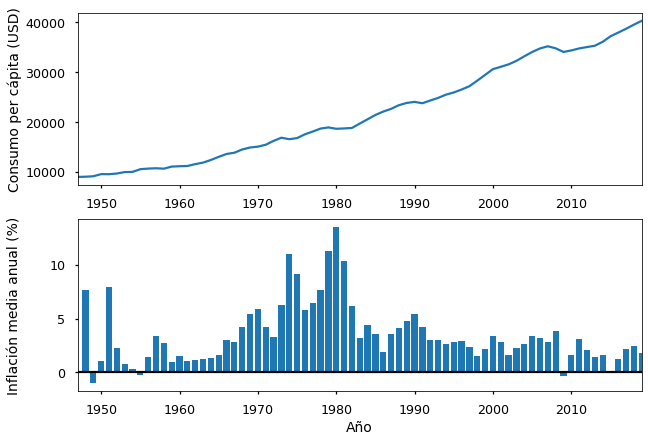

In [269]:
# Plot of real consumption per capita and inflation rate
fig = plt.figure()

plt.subplot(2, 1, 1)
plt.plot(data['rpc_consumption'])
axes = plt.gca()
axes.set_xlim([1947, 2019])
plt.ylabel('Consumo per cápita (USD)')

plt.subplot(2, 1, 2)
plt.bar(data.index, data['inflation']*100)
plt.axhline(0, color='black', linestyle='-')
axes = plt.gca()
axes.set_xlim([1947, 2019])
plt.ylabel('Inflación media anual (%)')

plt.xlabel('Año')
axes = plt.gca()
fig.align_ylabels()
if pub_quality: fig.savefig('figures/fig_consumo_inflacion.pdf', bbox_inches='tight')

We assume that gross consumption growth $c_t / c_{t-1}$ is lognormally distributed. This is the case only if its logarithm is normally distributed. Therefore we will conduct normality tests on $\ln(c_t / c_{t-1})$.

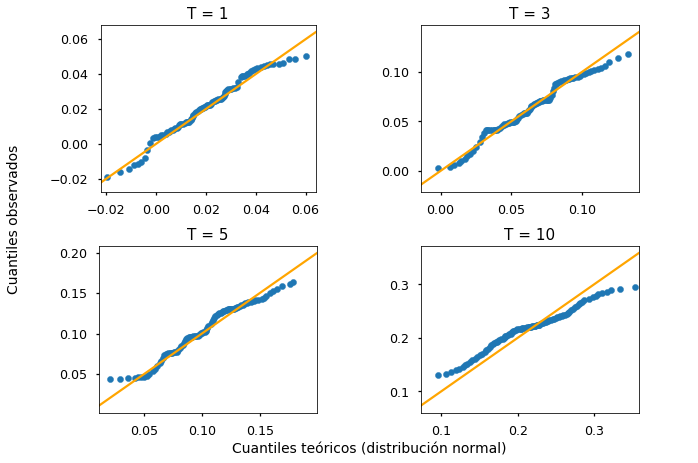

In [270]:
# The normality test results will be stored in a dictionary called 'normality_tests'
normality_tests = {t: None for t in t_list}

quants = {t: None for t in t_list}

quantiles = np.linspace(0,1,100)

for t in t_list:
    # Mean and standard deviation for the reference sample
    m = tdata[t]['log_delta_consumption_gross'].mean()
    s = tdata[t]['log_delta_consumption_gross'].std()

    # Test (data) sample
    test_sample = tdata[t]['log_delta_consumption_gross'].copy().dropna()
    normal_sample = pd.Series(np.random.normal(m, s, 1000))
    test_quantiles = test_sample.quantile(quantiles)
    normal_quantiles = normal_sample.quantile(quantiles)
    
    # Run some built-in normality tests
    normality_tests[t] = shapiro(test_sample), kstest(test_sample, 'norm', args=(m ,s)), anderson(test_sample, dist='norm')

    # Plot limits
    lim_inf = m - 2.5 * s
    lim_sup = m + 2.5 * s

    # Straight line
    straight = np.linspace(lim_inf, lim_sup, 10)
    
    quants[t] = {
        'test_quantiles': test_quantiles,
        'normal_quantiles': normal_quantiles,
        'straight': straight,
        'lim_inf': lim_inf,
        'lim_sup': lim_sup
    }    

t2axes = {
    1:  [0, 0],
    3:  [0, 1],
    5:  [1, 0],
    10: [1, 1]
}

# QQ plots
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.add_subplot(111, frame_on=False)

for t in t_list:
    axes[t2axes[t][0], t2axes[t][1]].plot(quants[t]['straight'], quants[t]['straight'], color='orange')
    axes[t2axes[t][0], t2axes[t][1]].scatter(quants[t]['normal_quantiles'], quants[t]['test_quantiles'], s=40)
    axes[t2axes[t][0], t2axes[t][1]].set_xlim([quants[t]['lim_inf'], quants[t]['lim_sup']])
    axes[t2axes[t][0], t2axes[t][1]].set_title('T = ' + str(t))
    axes[t2axes[t][0], t2axes[t][1]].set_aspect(0.7)

plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel('Cuantiles teóricos (distribución normal)')
plt.ylabel('Cuantiles observados')

fig.tight_layout()

if pub_quality: fig.savefig('figures/fig_qqplots.pdf', bbox_inches='tight')

In [271]:
# Show the results of the normality tests:
for T in normality_tests.keys():
    print('T=' + str(T), normality_tests[T],'\n')

T=1 (ShapiroResult(statistic=0.9777632355690002, pvalue=0.2394152581691742), KstestResult(statistic=0.07176932165192118, pvalue=0.8322467696864853), AndersonResult(statistic=0.36012523601594637, critical_values=array([0.548, 0.624, 0.749, 0.873, 1.039]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))) 

T=3 (ShapiroResult(statistic=0.9787319898605347, pvalue=0.8834728002548218), KstestResult(statistic=0.10406010446142763, pvalue=0.9426601195148988), AndersonResult(statistic=0.21271804064711475, critical_values=array([0.511, 0.582, 0.699, 0.815, 0.969]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))) 

T=5 (ShapiroResult(statistic=0.9622002243995667, pvalue=0.7872425317764282), KstestResult(statistic=0.1430313395989561, pvalue=0.9189390658446934), AndersonResult(statistic=0.23210396371063347, critical_values=array([0.497, 0.566, 0.679, 0.792, 0.942]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))) 

T=10 (ShapiroResult(statistic=0.9812653064727783, pva

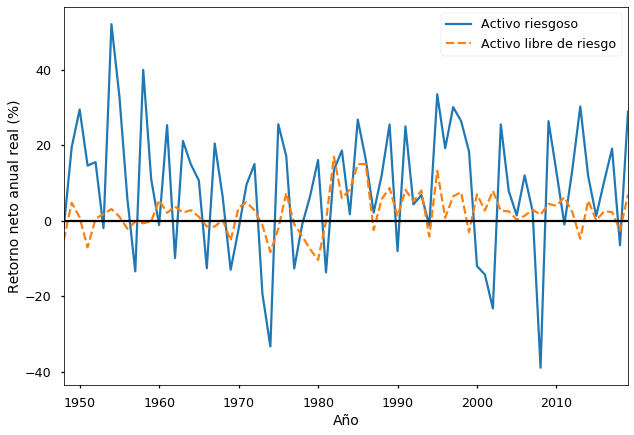

In [272]:
# Asset returns plot
fig = plt.figure()
plt.plot((data['r']-1)*100)
plt.plot((data['rf']-1)*100, linestyle='dashed')
plt.axhline(0, color='black', linestyle='-')
plt.legend(labels = ['Activo riesgoso', 'Activo libre de riesgo'])
plt.xlabel('Año')
plt.ylabel('Retorno neto anual real (%)')
axes = plt.gca()
axes.set_xlim([1948, 2019])
if pub_quality: fig.savefig('figures/fig_retornos.pdf', bbox_inches='tight')

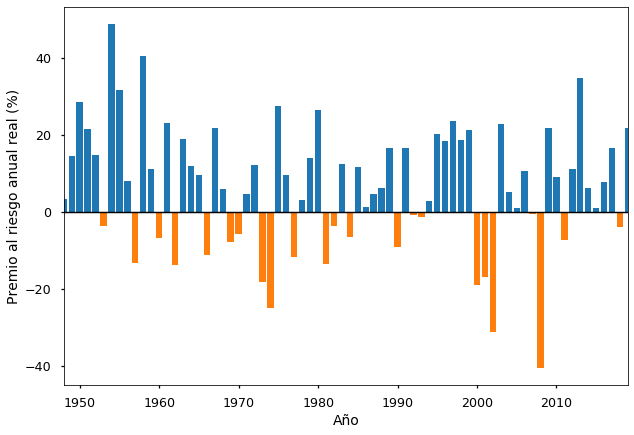

In [273]:
# Risk premium plot
fig = plt.figure()
plt.bar(data.query('risk_premium > 0').index, data.query('risk_premium > 0')['risk_premium']*100)
plt.bar(data.query('risk_premium < 0').index, data.query('risk_premium < 0')['risk_premium']*100)
plt.axhline(0, color='black', linestyle='-', linewidth=1.5)
plt.xlabel('Año')
plt.ylabel('Premio al riesgo anual real (%)')
axes = plt.gca()
axes.set_xlim([1948, 2019])
if pub_quality: fig.savefig('figures/fig_premio_al_riesgo.pdf', bbox_inches='tight')

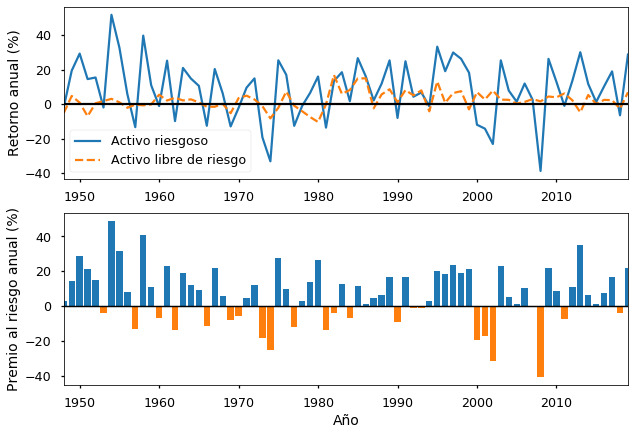

In [274]:
# Plot of real returns and risk premium
fig = plt.figure()

plt.subplot(2, 1, 1)
plt.plot((data['r']-1)*100)
plt.plot((data['rf']-1)*100, linestyle='dashed')
plt.axhline(0, color='black', linestyle='-')
axes = plt.gca()
axes.set_xlim([1948, 2019])
plt.ylabel('Retorno anual (%)')
plt.legend(labels = ['Activo riesgoso', 'Activo libre de riesgo'])

plt.subplot(2, 1, 2)
plt.bar(data.query('risk_premium > 0').index, data.query('risk_premium > 0')['risk_premium']*100)
plt.bar(data.query('risk_premium < 0').index, data.query('risk_premium < 0')['risk_premium']*100)
plt.axhline(0, color='black', linestyle='-', linewidth=1.5)
axes = plt.gca()
axes.set_xlim([1948, 2019])
plt.ylabel('Premio al riesgo anual (%)')

plt.xlabel('Año')
axes = plt.gca()
fig.align_ylabels()
if pub_quality: fig.savefig('figures/fig_retornos_premio.pdf', bbox_inches='tight')

# Model fitting

In [275]:
# Subjective discount factors (beta)
betas = [0.1, 0.5, 0.90, 0.95, 1.0]

# Maximum value of the relative risk aversion coefficient (gamma)
gamma_max = 150

# Subjective probabilities of not experiencing a consumption shock (pi_2)
pis = [0.2, 0.4, 0.6, 0.8, 1.0]

# Generate the sample space for gamma
points = 1000
gammas = np.linspace(0, gamma_max, points)

In [276]:
# The fitting results will be stored in a dictionary called 'treport'
treport = {t: None for t in t_list}

for t in t_list:
    # Mean returns
    r  = tdata[t]['r'].mean()
    rf = tdata[t]['rf'].mean()

    # Standard deviations
    sr  = tdata[t]['r'].std()
    sr2 = tdata[t]['r2'].std()

    # Mean and standard deviation of the rate of growth of consumption
    mc = tdata[t]['delta_consumption_gross'].mean() - 1
    sc = tdata[t]['delta_consumption_gross'].std()

    # The estimation of the return of the risky asset is stored in the dictioonary 'report'
    # Each key corresponds to a value of the beta parameter
    report = {beta: None for beta in betas}

    # Estimation of the return of the risky asset
    for beta in betas:
        # For each value of beta, the estimation is stored in a temporary dataframe called 'results'
        results = pd.DataFrame({'gamma': gammas})
        # Loop over the values of the pi parameter
        for pi in pis:
            # For each value of pi, the estimation is stored in 'result'
            result = []
            for gamma in gammas:
                # Calculate the first and second central moments of the delta discount factor
                md1 = beta * np.exp(- gamma * mc + gamma ** 2 * sc ** 2 / 2)
                md2 = beta ** 2 * np.exp(- 2 * gamma * mc + gamma ** 2 * sc ** 2)
                sd1 = np.sqrt(beta ** 2 * np.exp(- 2 * gamma * mc + gamma ** 2 * sc ** 2) * (np.exp(gamma ** 2 * sc ** 2) - 1))
                sd2 = np.sqrt(beta ** 4 * np.exp(- 4 * gamma * mc + 2 * gamma ** 2 * sc ** 2) * (np.exp(2 * gamma ** 2 * sc ** 2) - 1))
                # Auxiliary factor c
                c = (pi - 1) * sd1 * sr - pi ** 2 * sd2 * sr2 - md1 * rf - pi * md2 * rf ** 2
                # Estimator
                r_estimation = (- md1 + np.sqrt(md1 ** 2 - 4 * pi * md2 * c)) / (2 * pi * md2)
                # The estimator is annualized for an easier interpretation
                r_estimation = r_estimation ** (1 / T)
                # Store
                result.append((r_estimation - 1) * 100)
            # Store
            results[str(pi)] = result
        # Store
        report[beta] = results
    # Store
    treport[t] = report

# Take a look
treport[1][0.95].head()

,gamma,0.2,0.4,0.6,0.8,1.0
0,0.000000,0.212675,0.212675,0.212675,0.212675,0.212675
1,0.150150,0.215446,0.214960,0.214982,0.215279,0.215744
2,0.300300,0.218219,0.217245,0.217286,0.217878,0.218805
3,0.450450,0.220995,0.219531,0.219587,0.220472,0.221858
4,0.600601,0.223772,0.221818,0.221887,0.223061,0.224903


In [277]:
# Line markers for each probability (this is just styling stuff)
markers = {
    0.2: '$A$',
    0.4: '$B$',
    0.6: '$C$',
    0.8: '$D$',
    1.0: '$E$'
}

# Override markers
markers = {pi: None for pi in pis}

# Labels for each probability
labels = ['$\pi_2 = $' + str(pi) for pi in pis]

# Plotting function
def graph(T, beta):
    fig = plt.figure()
    for pi in pis:
        plt.plot(gammas, treport[t][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(700,2000), markerfacecolor='black')
    plt.axhline((tdata[t]['r'].mean() ** (1/T) - 1) * 100, color='black', linestyle='dashed')
    plt.axhline((tdata[t]['rf'].mean() ** (1/T) - 1) * 100, color='black', linestyle='dotted')
    plt.xlabel('Coeficiente de aversión relativa al riesgo')
    plt.ylabel('Retorno neto anualizado (%)')
    plt.legend(labels = labels + ['Activo riesgoso (media)', 'Activo sin riesgo (media)'], bbox_to_anchor=(0.5, -0.37), loc='lower center', ncol=3)
    plt.grid(linestyle="-", linewidth=0.5)
    axes = plt.gca()
    axes.set_xlim([0, 140])
    axes.set_ylim([0, 9])
    plt.title('T = ' + str(t))
    plt.axvspan(0, 10, alpha=0.1, color='black')
    if pub_quality: fig.savefig('figures/fig_resultados_beta_' + str(int(100 * beta)) + '_t_' + str(t) + '.pdf', bbox_inches='tight')

/usr/local/Cellar/graph-tool/2.37/libexec/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/Cellar/graph-tool/2.37/libexec/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


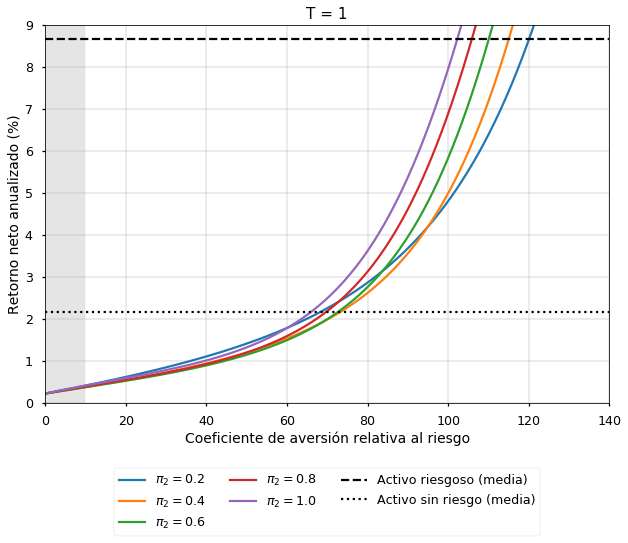

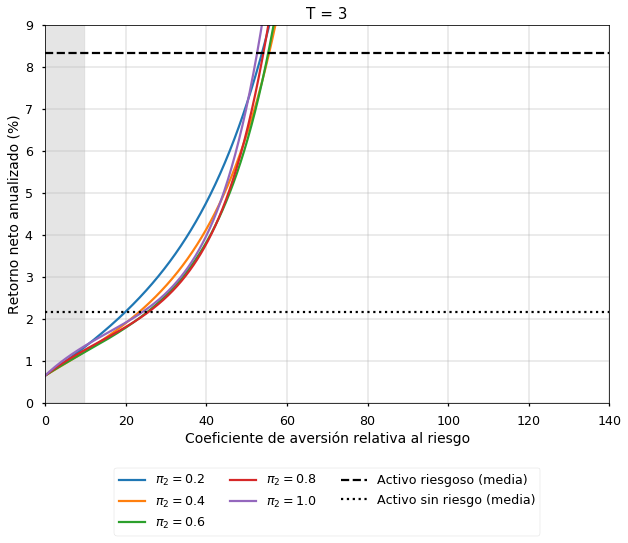

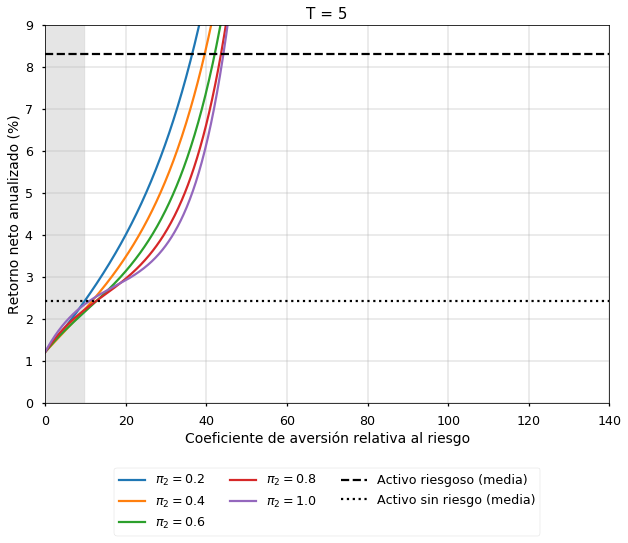

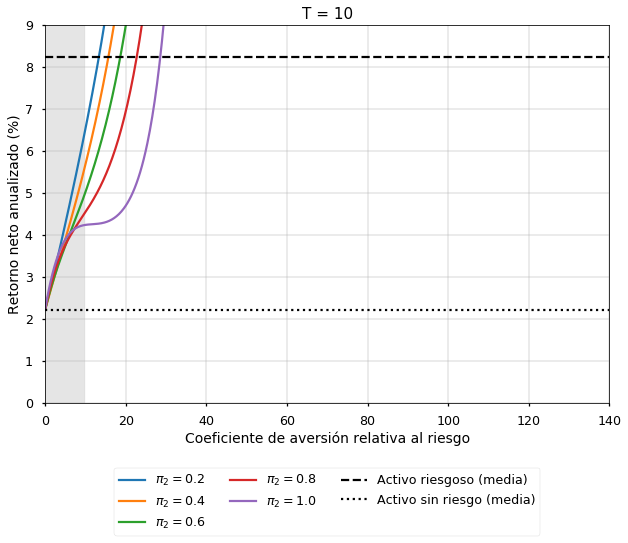

In [278]:
# Plot the results for the given value of beta
beta = 0.95
for t in t_list:
    graph(t, beta)

<Figure size 728x500.5 with 0 Axes>

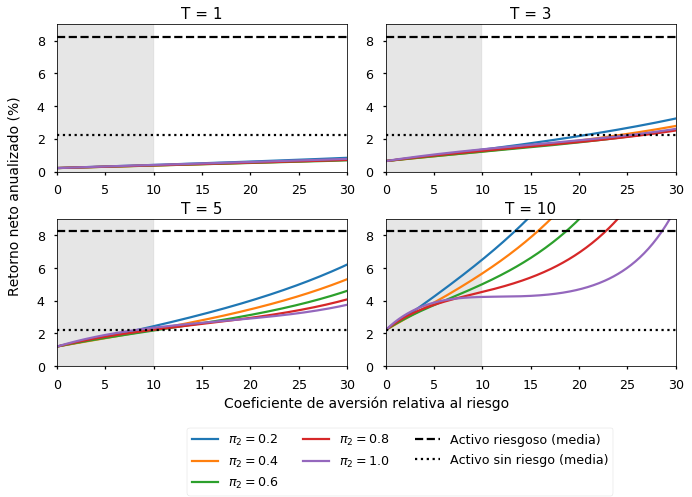

In [279]:
# A more compact plot
plt.gcf().clear()
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.add_subplot(111, frame_on=False)

beta = 0.95

for pi in pis:
    axes[0, 0].plot(gammas, treport[1][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[0, 1].plot(gammas, treport[3][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 1].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 0].plot(gammas, treport[5][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 1].plot(gammas, treport[10][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 1].axvspan(0, 10, alpha=0.04, color='gray')

for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].axhline((tdata[t]['r'].mean() ** (1/T) - 1) * 100, color='black', linestyle='dashed')
        axes[i, j].axhline((tdata[t]['rf'].mean() ** (1/T) - 1) * 100, color='black', linestyle='dotted')

axes[0, 0].set_title('T = 1')
axes[0, 1].set_title('T = 3')
axes[1, 0].set_title('T = 5')
axes[1, 1].set_title('T = 10')

plt.setp(axes, xlim=(0, 30), ylim=(0, 9))
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel('Coeficiente de aversión relativa al riesgo')
plt.ylabel('Retorno neto anualizado (%)')

fig.legend(labels = labels + ['Activo riesgoso (media)', 'Activo sin riesgo (media)'], bbox_to_anchor=(0.55, -0.01), loc='lower center', ncol=3)
fig.tight_layout()

fig.subplots_adjust(bottom=0.25)

if pub_quality: fig.savefig('figures/fig_resultados_comparativo_beta_' + str(int(100 * beta)) + '.pdf', bbox_inches='tight')

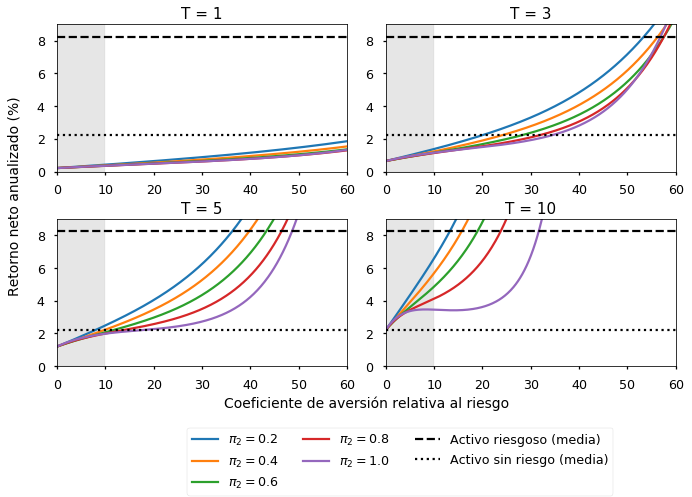

In [280]:
str(int(100 * beta))# A more compact plot
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.add_subplot(111, frame_on=False)

beta = 0.5

for pi in pis:
    axes[0, 0].plot(gammas, treport[1][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[0, 1].plot(gammas, treport[3][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 1].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 0].plot(gammas, treport[5][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 1].plot(gammas, treport[10][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 1].axvspan(0, 10, alpha=0.04, color='gray')

for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].axhline((tdata[t]['r'].mean() ** (1/T) - 1) * 100, color='black', linestyle='dashed')
        axes[i, j].axhline((tdata[t]['rf'].mean() ** (1/T) - 1) * 100, color='black', linestyle='dotted')
        #axes[i, j].grid(linestyle="-", linewidth=0.5)

axes[0, 0].set_title('T = 1')
axes[0, 1].set_title('T = 3')
axes[1, 0].set_title('T = 5')
axes[1, 1].set_title('T = 10')

plt.setp(axes, xlim=(0,60), ylim=(0, 9))
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel('Coeficiente de aversión relativa al riesgo')
plt.ylabel('Retorno neto anualizado (%)')

fig.legend(labels = labels + ['Activo riesgoso (media)', 'Activo sin riesgo (media)'], bbox_to_anchor=(0.55, -0.01), loc='lower center', ncol=3)
fig.tight_layout()

fig.subplots_adjust(bottom=0.25)

if pub_quality: fig.savefig('figures/fig_resultados_comparativo_beta_' + str(int(100 * beta)) + '.pdf', bbox_inches='tight')

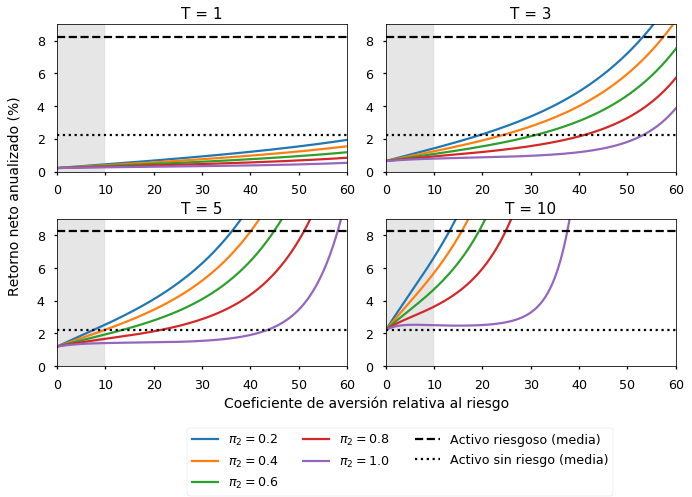

In [281]:
# A more compact plot
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.add_subplot(111, frame_on=False)

beta = 0.1

for pi in pis:
    axes[0, 0].plot(gammas, treport[1][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[0, 1].plot(gammas, treport[3][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[0, 1].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 0].plot(gammas, treport[5][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 0].axvspan(0, 10, alpha=0.04, color='gray')
for pi in pis:
    axes[1, 1].plot(gammas, treport[10][beta][str(pi)], marker=markers[pi], markersize=9, markevery=(110,2000), markerfacecolor='black')
    axes[1, 1].axvspan(0, 10, alpha=0.04, color='gray')

for i in range(0, 2):
    for j in range(0, 2):
        axes[i, j].axhline((tdata[t]['r'].mean() ** (1/T) - 1) * 100, color='black', linestyle='dashed')
        axes[i, j].axhline((tdata[t]['rf'].mean() ** (1/T) - 1) * 100, color='black', linestyle='dotted')
        #axes[i, j].grid(linestyle="-", linewidth=0.5)

axes[0, 0].set_title('T = 1')
axes[0, 1].set_title('T = 3')
axes[1, 0].set_title('T = 5')
axes[1, 1].set_title('T = 10')

plt.setp(axes, xlim=(0,60), ylim=(0, 9))
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel('Coeficiente de aversión relativa al riesgo')
plt.ylabel('Retorno neto anualizado (%)')

fig.legend(labels = labels + ['Activo riesgoso (media)', 'Activo sin riesgo (media)'], bbox_to_anchor=(0.55, -0.01), loc='lower center', ncol=3)
fig.tight_layout()

fig.subplots_adjust(bottom=0.25)

if pub_quality: fig.savefig('figures/fig_resultados_comparativo_beta_' + str(int(100 * beta)) + '.pdf', bbox_inches='tight')